### Підключення бібліотек та ініціалізація необхідних змінних

In [7]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

img_gray = cv.imread('images/1.jpg',0)
img_color = cv.imread('images/1.jpg')

channels = cv.split(img_color.copy()) # Розділяємо кадр на канали B, G, R
histSize, histRange = 256, (0, 256)
accumulate = False

colors = ['b', 'g', 'r']
channels_names = ["Blue", "Green", "Red"]

### 1. Реалізація обчислення гістрограми яскравості для кольорового зображення

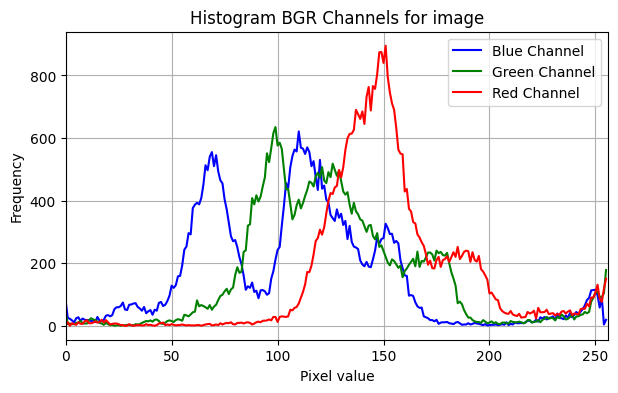

In [8]:
plt.figure(figsize=(7,4))
for i, color in enumerate(colors): # Перебираємо всі канали та їх відповідні кольори
    hist = cv.calcHist([channels[i]], [0], None, [histSize], histRange, accumulate=accumulate)
    # cv.calcHist отримує канал зображення, індекс каналу (тут [0] – для одного каналу),
    # None означає, що маска не використовується, histSize – кількість бінів у гістограмі, 
    # histRange – діапазон значень пікселів (0-255 для BGR), accumulate – чи потрібно накопичувати гістограму.
    
    plt.plot(hist, color=color, label=f"{channels_names[i]} Channel")
    plt.xlim(histRange)

plt.title('Histogram BGR Channels for image')
plt.xlabel('Pixel value'), plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

### 2. Обчислення гістрограми для потокового відео з файлу

End of video or cannot fetch the frame.


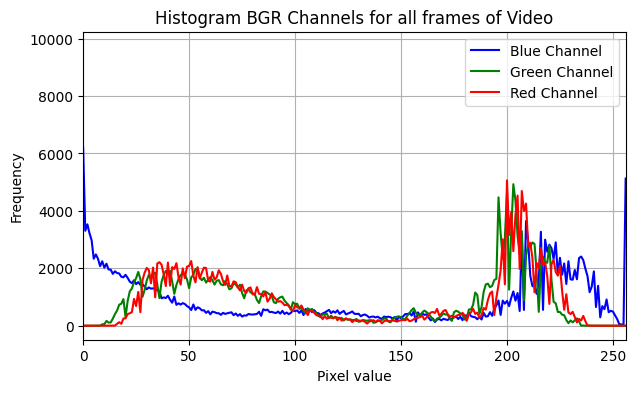

In [9]:
video_path = "videos/video.mp4"
cap = cv.VideoCapture(video_path)

if not cap.isOpened(): # Перевіряємо, чи вдалося відкрити відео
    print("Error: Could not open video.")
    exit()

all_sum_channels = [[] for _ in range(3)]
# Ініціалізуємо порожні списки для збереження гістограм кожного каналу (B, G, R)

while True:
    ret, frame = cap.read() # Зчитуємо наступний кадр із відео
    if not ret: # Якщо кадр не зчитано (кінець відео або помилка)
        print("End of video or cannot fetch the frame.")
        break

    channels = cv.split(frame)
    for i in range(len(colors)): # Перебираємо кожен канал
        all_sum_channels[i].append(cv.calcHist([channels[i]], [0], None, [histSize], histRange, accumulate=accumulate))
        # Обчислюємо гістограму для кожного каналу та додаємо її до відповідного списку
        
    if cv.waitKey(0) & 0xFF == ord('q'):
        break

cap.release()
cv.destroyAllWindows()

plt.figure(figsize=(7,4))
for i, color in enumerate(colors):
    plt.plot(np.concatenate(all_sum_channels[i]), color=color, label=f"{channels_names[i]} Channel")
    plt.xlim(histRange)
plt.title('Histogram BGR Channels for all frames of Video')
plt.xlabel('Pixel value'), plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

Обчислення гістограм BGR-каналів для всіх кадрів відео допомагає виявити загальні тенденції в освітленості та кольорових каналах. Візуалізація гістограм для відео дає уявлення про зміну кольорового балансу або освітлення.

### 3. Реалізація вирівнювання гістограми будь-якого зображення

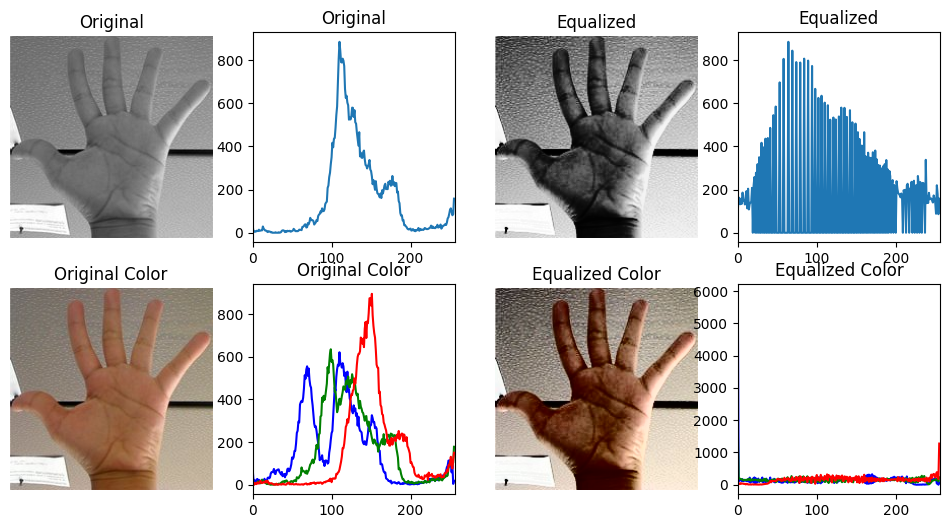

In [10]:
image_gray = img_gray.copy()
image_color = img_color.copy()

equalized_image_gray = cv.equalizeHist(image_gray.copy()) 
# Використовуємо вирівнювання гістограми для сірого зображення
hist_gray = cv.calcHist([image_gray], [0], None, [histSize], histRange, accumulate=accumulate)
# Обчислюємо гістограму для оригінального сірого зображення
hist_equalized_gray = cv.calcHist([equalized_image_gray], [0], None, [histSize], histRange, accumulate=accumulate)
# Обчислюємо гістограму для вирівняного сірого зображення

yuv_image_color = cv.cvtColor(image_color, cv.COLOR_BGR2YUV)
# Перетворюємо кольорове зображення з BGR в YUV
yuv_image_color[:,:,0] = cv.equalizeHist(yuv_image_color[:,:,0])
# Вирівнюємо гістограму для Y-каналу (освітленості)
equalized_image_color = cv.cvtColor(yuv_image_color, cv.COLOR_YUV2BGR)
# Повертаємо зображення в колірний простір BGR
hist_color = [cv.calcHist([image_color], [i], None, [histSize], histRange) for i in range(3)]
# Обчислюємо гістограми для кожного каналу кольорового зображення (B, G, R)
hist_equalized_color = [cv.calcHist([equalized_image_color], [i], None, [histSize], histRange) for i in range(3)]
# Обчислюємо гістограми для кожного каналу вирівняного кольорового зображення


# Створюємо все це для зручного відображення
hists = [hist_gray, hist_equalized_gray, hist_color, hist_equalized_color]
images = [image_gray, equalized_image_gray, image_color, equalized_image_color]
titles = ['Original', 'Equalized', 'Original Color', 'Equalized Color']

plt.figure(figsize=(12,6)) 
for i, (hist, img, title) in enumerate(zip(hists, images, titles)):
    # Демонстрація зображення 
    plt.subplot(2, 4, 2*i+1)
    plt.title(title)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

    # Демонстрація графіку
    plt.subplot(2, 4, 2*i+2)
    plt.title(title)
    if len(img.shape) == 2:
        plt.plot(hist)
    else:
        colors = ('b', 'g', 'r')
        for j, col in enumerate(colors):
            plt.plot(hist[j], color=col)
    plt.xlim([0, 256])

Вирівнювання гістограм для сірого та кольорового зображень покращує контраст, але може призводити до перенасичення на світлих або темних ділянках.
Конвертація в YUV дозволяє покращувати контраст тільки в Y-каналі (освітленість), зберігаючи точність кольорів. Це ефективний метод для кольорових зображень.

### 4. Реалізація адаптивного вирівнювання за методом CLAHE

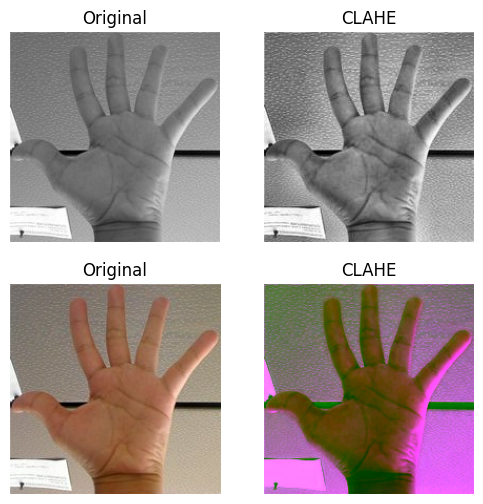

In [11]:
image_gray = img_gray.copy()
image_color = img_color.copy()
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
# Створюємо об'єкт CLAHE (обмежене адаптивне вирівнювання гістограми) з параметрами clipLimit і tileGridSize.
# clipLimit контролює контраст (якщо він занадто великий, рівні яскравості обмежуються), 
# tileGridSize визначає розмір області, на якій буде застосоване вирівнювання.

cl_image_gray = clahe.apply(image_gray)

yuv_image = cv.cvtColor(image_color, cv.COLOR_BGR2YUV)
yuv_image[:,:,0] = clahe.apply(yuv_image[:,:,0])
cl_image_color = cv.cvtColor(image_color, cv.COLOR_YUV2BGR)

images = [image_gray, cl_image_gray, image_color, cl_image_color]
titles = ['Original','CLAHE','Original','CLAHE']

plt.figure(figsize=(6,6))
for i, (img, title) in enumerate(zip(images, titles)):
    plt.subplot(2, 2, i+1)
    plt.title(title)
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.axis('off')

CLAHE показав кращі результати для покращення контрасту в деталізованих зображеннях, оскільки цей метод запобігає надмірному підсиленню контрасту, особливо в областях із високою щільністю пікселів.
Конвертація в YUV дає змогу зберегти правильні кольори, зосереджуючи контрастування лише на освітленості. CLAHE є кращим вибором для обробки зображень з нерівномірним освітленням або кольоровими артефактами.